This is the pytorch implementation of the deep learning model proposed in the paper 'A Deep Model for Multi-Focus Image Fusion Based on Gradients and Connected Regions'

In [16]:
#Import packages
import time
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib.pyplot as plt
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [18]:
import multiprocessing
multiprocessing.cpu_count()

12

In [19]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 50
learning_rate = 0.0002 

In [20]:
#load the train mri data
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Training/MRI')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Training/MRI')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    train_mri[i,:,:] =(imageio.imread(data[i]))
    train_mri[i,:,:] =(train_mri[i,:,:] - np.min(train_mri[i,:,:])) / (np.max(train_mri[i,:,:]) - np.min(train_mri[i,:,:]))
    train_mri[i,:,:] = np.float32(train_mri[i,:,:])

In [21]:
#expand dimension to add the channel
train_mri = np.expand_dims(train_mri,axis=1)

In [22]:
#verify the shape matches the pytorch standard
train_mri.shape

(272, 1, 256, 256)

In [23]:
#convert the MRI training data to pytorch tensor
train_mri_tensor = torch.from_numpy(train_mri).float()
train_mri_tensor.shape

torch.Size([272, 1, 256, 256])

In [24]:
#load the train pet data
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/Training/PET')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/Training/PET')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
train_other = np.zeros((len(data),image_width,image_length,pet_channels),dtype=float)
train_pet = np.zeros((len(data),image_width,image_length),dtype=float)
for i in range(len(data)):
    train_other[i,:,:,:] =(imageio.imread(data[i]))
    train_pet[i,:,:] = 0.2989 * train_other[i,:,:,0] + 0.5870 *  train_other[i,:,:,1]  + 0.1140 * train_other[i,:,:,2]
    train_pet[i,:,:] =(train_pet[i,:,:] - np.min(train_pet[i,:,:])) / (np.max(train_pet[i,:,:]) - np.min(train_pet[i,:,:]))

In [25]:
#expand the dimension to add the channel
train_pet = np.expand_dims(train_pet,axis=1)

In [26]:
#verify the shape matches the pytorch standard
train_pet.shape

(272, 1, 256, 256)

In [27]:
#convert the PET training data to pytorch tensor
train_pet_tensor = torch.from_numpy(train_pet).float()
train_pet_tensor.shape

torch.Size([272, 1, 256, 256])

In [49]:
#define the Mask-Net network
class MaskNet(nn.Module):
    def  __init__(self):
        super(MaskNet, self).__init__()
        #####encoder layer 1#####
        self.layer1 = nn.Sequential(  #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,48,256,256)   
        #####encoder layer 2#####
        self.layer2 = nn.Sequential(  #input shape (,48,256,256)
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)
        #####encoder layer 3#####
        self.layer3 = nn.Sequential(  #input shape (,96,256,256)
                         nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)     
        #####encoder layer 4#####
        self.layer4 = nn.Sequential(  #input shape (,144,256,256)
                         nn.Conv2d(in_channels = 144, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256) 
        #####decoder layer 1#####
        self.layer5 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(192),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,192,256,256)    
        #####decoder layer 2#####
        self.layer6 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(128),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,128,256,256)    
        #####decoder layer 3#####
        self.layer7 = nn.Sequential(  #input shape (,128,256,256)
                         nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,64,256,256)  
        #####decoder layer 4#####
        self.layer8 = nn.Sequential(  #input shape (,64,256,256)
                         nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(1),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,1,256,256)          
 
    def forward(self, x, y):
        #encoder layer 1
        en1 = self.layer1(torch.cat((x,y),dim=1))
        #encoder layer 2
        en2 = self.layer2(en1)
        #concat layer 1
        concat1 = torch.cat((en1,en2),dim=1)
        #encoder layer 3
        en3 = self.layer3(concat1)
        #concat layer 2
        concat2 = torch.cat((concat1,en3),dim=1)
        #encoder layer 4
        en4 = self.layer4(concat2)
        #concat layer 3
        concat3 = torch.cat((concat2,en4),dim=1)
        #decoder layer 1
        dec1 = self.layer5(concat3)
        #decoder layer 2
        dec2 = self.layer6(dec1)
        #decoder layer 3
        dec3 = self.layer7(dec2)
        #decoder layer 4
        dec4 = self.layer8(dec3)
        #tanh layer
        fused = torch.tanh(dec4)      
        return fused
        #execute the network

cnn = MaskNet().to(device)
cnn = cnn.float()
print(cnn)

MaskNet(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(144, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer5): Sequential(
    (0)

In [50]:
#define the optimizers and loss functions 
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)   #optimize all cnn parameters
MSE_loss   = nn.MSELoss()                                           #MSEloss

In [51]:
# perform the training
counter = 0
start_time = time.time()
lamda = 1
ep_ssim_mri_loss = []
ep_ssim_pet_loss = []
for epoch in range(EPOCH):
    ssim_mri_Loss = []
    ssim_pet_Loss   = []
    #run batch images
    batch_idxs = 272 // batch_size
    for idx in range(0, batch_idxs):
        #reconstruct mri
        b_x = train_mri_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        b_y = train_pet_tensor[idx*batch_size : (idx+1)*batch_size,:,:,:].to(device)
        counter += 1
        #encoder
        output = cnn(b_x,b_y) 
        #loss        
        ssim_mri_loss = 1 - ssim(output, b_x,data_range=1)
        ssim_pet_loss = 1 - ssim(output, b_y,data_range=1)
        loss_total = ssim_mri_loss + ssim_pet_loss
        optimizer.zero_grad()              # clear gradients for this training step
        loss_total.backward()              # backpropagation, compute gradients
        optimizer.step()                   # apply gradients
                
        ssim_mri_Loss.append(ssim_mri_loss.item())
        ssim_pet_Loss.append(ssim_pet_loss.item())
        
        if counter % 100 == 0:
            print("Epoch: [%2d],step: [%2d], ssim_mri_loss: [%.8f], ssim_pet_loss: [%.8f], total_loss: [%.8f]" 
                   %(epoch, counter, ssim_mri_loss, ssim_pet_loss, loss_total))
    
    av_ssim_mri_loss = np.average(ssim_mri_Loss)
    ep_ssim_mri_loss.append(av_ssim_mri_loss)
    
    av_ssim_pet_loss = np.average(ssim_pet_Loss)
    ep_ssim_pet_loss.append(av_ssim_pet_loss)
    
    if(epoch == EPOCH -1):
        #Save a checkpoint
        torch.save(cnn, 'C:/Users/horan/Desktop/Suraka/.ipynb_checkpoints/MaskNet/checkpoint.pth') 

Epoch: [ 0],step: [100], ssim_mri_loss: [0.30408281], ssim_pet_loss: [0.27843350], total_loss: [0.58251631]
Epoch: [ 0],step: [200], ssim_mri_loss: [0.61665058], ssim_pet_loss: [0.53206158], total_loss: [1.14871216]
Epoch: [ 1],step: [300], ssim_mri_loss: [0.35848594], ssim_pet_loss: [0.44155943], total_loss: [0.80004537]
Epoch: [ 1],step: [400], ssim_mri_loss: [0.16218597], ssim_pet_loss: [0.15696067], total_loss: [0.31914663]
Epoch: [ 1],step: [500], ssim_mri_loss: [0.79653072], ssim_pet_loss: [0.38177544], total_loss: [1.17830610]
Epoch: [ 2],step: [600], ssim_mri_loss: [0.53800988], ssim_pet_loss: [0.44602150], total_loss: [0.98403138]
Epoch: [ 2],step: [700], ssim_mri_loss: [0.34456712], ssim_pet_loss: [0.42103213], total_loss: [0.76559925]
Epoch: [ 2],step: [800], ssim_mri_loss: [0.21524978], ssim_pet_loss: [0.31623769], total_loss: [0.53148746]
Epoch: [ 3],step: [900], ssim_mri_loss: [0.24455869], ssim_pet_loss: [0.20656651], total_loss: [0.45112520]
Epoch: [ 3],step: [1000], ss

Epoch: [28],step: [7700], ssim_mri_loss: [0.19677180], ssim_pet_loss: [0.20366973], total_loss: [0.40044153]
Epoch: [28],step: [7800], ssim_mri_loss: [0.39020759], ssim_pet_loss: [0.36947155], total_loss: [0.75967914]
Epoch: [29],step: [7900], ssim_mri_loss: [0.12752116], ssim_pet_loss: [0.30013990], total_loss: [0.42766106]
Epoch: [29],step: [8000], ssim_mri_loss: [0.16696763], ssim_pet_loss: [0.10614902], total_loss: [0.27311665]
Epoch: [29],step: [8100], ssim_mri_loss: [0.18687338], ssim_pet_loss: [0.25342554], total_loss: [0.44029891]
Epoch: [30],step: [8200], ssim_mri_loss: [0.22874701], ssim_pet_loss: [0.46456295], total_loss: [0.69330996]
Epoch: [30],step: [8300], ssim_mri_loss: [0.17835760], ssim_pet_loss: [0.15462703], total_loss: [0.33298463]
Epoch: [30],step: [8400], ssim_mri_loss: [0.25368297], ssim_pet_loss: [0.20275635], total_loss: [0.45643932]
Epoch: [31],step: [8500], ssim_mri_loss: [0.35367179], ssim_pet_loss: [0.33116454], total_loss: [0.68483633]
Epoch: [31],step: [

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type MaskNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [52]:
l1 = np.asarray(ep_ssim_mri_loss)
l2 = np.asarray(ep_ssim_pet_loss)

In [54]:
h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Loss curves/MaskNet/H5 Files/Loss_SSIM_PET.h5', 'w')
h5f.create_dataset('PET_dataset', data=l2)
h5f.close()

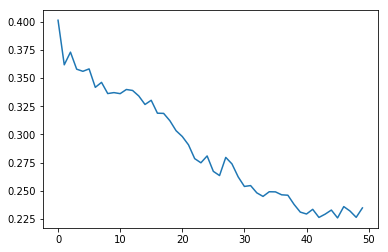

In [56]:
plt.plot(l2)
#plt.savefig('C:/Users/horan/Desktop/Suraka/Loss curves/VIFNet/Loss curves/SSIM_MRI_loss_curve.png', bbox_inches = 'tight',pad_inches = 0)
#plt.close()

In [57]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [58]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

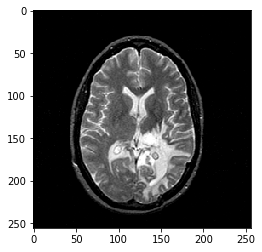

In [59]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [60]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [61]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/Suraka/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/Suraka/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [62]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(1, 1, 256, 256)

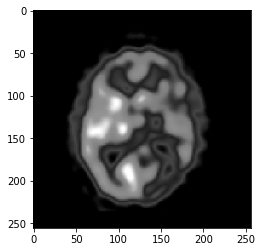

In [63]:
plt.imshow(test_pet[0,0,:,:],'gray')
#plt.savefig('PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [64]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [65]:
#load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn =torch.load('C:/Users/horan/Desktop/Suraka/.ipynb_checkpoints/MaskNet/checkpoint.pth')
cnn.eval()

MaskNet(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(144, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer5): Sequential(
    (0)

In [66]:
#predicted the fused image
fuse_test = cnn(test_mri_tensor.to(device),test_pet_tensor.to(device))
fused_numpy = fuse_test.data.cpu().numpy()

In [68]:
fuse_test.shape

torch.Size([1, 1, 256, 256])

In [69]:
fused_numpy

array([[[[-0.14104456, -0.06976022, -0.07484604, ..., -0.08061825,
          -0.071153  , -0.03332005],
         [-0.21483874, -0.04924786, -0.01156501, ..., -0.0179201 ,
          -0.03311176, -0.00344966],
         [-0.25596288, -0.05388603, -0.0088764 , ..., -0.01055707,
          -0.03329092, -0.00778092],
         ...,
         [-0.25589305, -0.06229866, -0.01076435, ..., -0.00767235,
          -0.027253  , -0.00390313],
         [-0.21614458, -0.07306459, -0.03176408, ..., -0.03265187,
          -0.04283653, -0.01551002],
         [-0.11944459, -0.06106373, -0.04208053, ..., -0.0380417 ,
          -0.04064364, -0.0250441 ]]]], dtype=float32)

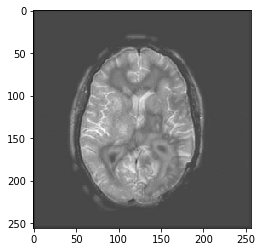

In [70]:
#verify the output image
plt.imshow(fused_numpy[0,0,:,:],'gray')
#plt.savefig('Fused.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#imageio.imwrite('C:/Users/horan/Desktop/Suraka/Fused/Fused.png',np.uint8(cv2.normalize(fused_numpy[0,0,:,:], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)))

In [ ]:
#calculate the guidance image for MRI and PET wrt to the fused image
time1 = time.time()
count = 0 
guide_fuse_mri = np.zeros((256,256),dtype=float)
guide_fuse_pet = np.zeros((256,256),dtype=float)

for y_coord in range(0,256):
    for x_coord in range(0,256):
        jacob_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_mri = np.squeeze(jacob_fuse_mri.data.cpu().numpy())  
        guide_fuse_mri[y_coord,x_coord] = jacob_numpy_mri[y_coord,x_coord]
        jacob_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
        jacob_numpy_pet = np.squeeze(jacob_fuse_pet.data.cpu().numpy())  
        guide_fuse_pet[y_coord,x_coord] = jacob_numpy_pet[y_coord,x_coord]
        count += 1
        if count % 100 == 0:
            print('Count is %d' %count)
time2 = time.time()
print('Time taken to compute is %d seconds' %(time2-time1))

In [ ]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()
#plt.savefig('Jacob_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#guide_fuse_mri.shape

In [ ]:
#plt.imshow(guide_fuse_pet,cmap='viridis')
#plt.colorbar()
#plt.savefig('Jacob_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#guide_fuse_pet.shape

In [ ]:
#plt.imshow(fused_RGB)
#plt.savefig('Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#plt.imshow(mri_RGB)
#plt.savefig('MRI_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#plt.imshow(pet_RGB)
#plt.savefig('PET_RGB.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Jacobian_MRI.h5', 'w')
#h5f.create_dataset('MRI_dataset', data=guide_fuse_mri)
#h5f.close()

In [ ]:
#h5f = h5py.File('C:/Users/horan/Desktop/Suraka/Jacobian_PET.h5', 'w')
#h5f.create_dataset('PET_dataset', data=guide_fuse_pet)
#h5f.close()

In [ ]:
hf = h5py.File('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/H5 Files/Jacobian_MRI.h5', 'r')
guide_fuse_mri =  np.array(hf.get('MRI_dataset'))
hf.close()

In [ ]:
plt.imshow(guide_fuse_mri,cmap='viridis')
plt.colorbar()

In [ ]:
hf = h5py.File('C:/Users/horan/Desktop/Suraka/Guidance images/FunFuseAn/H5 Files/Jacobian_PET.h5', 'r')
guide_fuse_pet =  np.array(hf.get('PET_dataset'))
hf.close()

In [ ]:
plt.imshow(guide_fuse_pet,cmap='viridis')
plt.colorbar()

In [ ]:
#define overlay images
fused_RGB = np.zeros((256,256,3),dtype=float)
mri_RGB   = np.zeros((256,256,3),dtype=float)
pet_RGB   = np.zeros((256,256,3),dtype=float)

In [ ]:
fused_RGB[:,:,0]  = guide_fuse_mri 
fused_RGB[:,:,1]  = guide_fuse_pet 
fused_RGB[:,:,2]  = fused_numpy[0,0,:,:]

In [ ]:
plt.imshow(fused_RGB)

In [ ]:
mri_RGB[:,:,0]  = guide_fuse_mri
mri_RGB[:,:,1]  = guide_fuse_pet 
mri_RGB[:,:,2]  = test_mri[0,0,:,:]

In [ ]:
plt.imshow(mri_RGB)

In [ ]:
pet_RGB[:,:,0]  = guide_fuse_mri
pet_RGB[:,:,1]  = guide_fuse_pet 
pet_RGB[:,:,2]  = test_pet[0,0,:,:]

In [ ]:
plt.imshow(pet_RGB)

In [ ]:
#define the window
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')


#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame


#define the canvas
canvas = Canvas(canvasframe, width=1800, height=920, bg = 'white')
canvas.grid(row=0, column=0)

#Insert fused image to the canvas
img_fused = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/Fused/Fused.png") # load the image
canvas.create_image(0, 0, image=img_fused, anchor=NW)

#Insert MRI image to the canvas
img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/MRI/MRI.gif") # load the image
canvas.create_image(620, 0, image=img_mri, anchor=NW)

#Insert PET image to the canvas
img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/Suraka/PET/3.png") # load the image
canvas.create_image(1240, 0, image=img_pet, anchor=NW)

def start_mouseover():  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    canvas.bind("<B1-Motion>", Coordinates)

def Coordinates(event): # function called when left-mouse-button is clicked with a mouseover
    x_coord = event.x  # save x and y coordinates selected by the user   
    y_coord = event.y
    print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
    #display the output MRI Jacobian image
    #img_MR_out = ImageTk.PhotoImage(file ='C:/Users/cgvadmin/Desktop/Suraka/Fused_MRI/im_' + str(y_coord) + '_' + str(x_coord) + '.png') # load the image
    jacobian_fuse_mri = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
    jacobian_fuse_pet = torch.autograd.grad(fused[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]
    
    jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
    jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
    
    x_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 0)))
    y_mri = np.asarray(np.where(np.any(jacob_val_mri, axis = 1)))
    minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
    zoom_im_mri = jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri] 
    
    x_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 0)))
    y_pet = np.asarray(np.where(np.any(jacob_val_pet, axis = 1)))
    minx_pet, maxx_pet, miny_pet, maxy_pet = np.min(x_pet), np.max(x_pet), np.min(y_pet), np.max(y_pet)  #return min and max coordinates
    zoom_im_pet = jacob_val_pet[miny_pet:maxy_pet,minx_pet:maxx_pet] 
    
    plt.imshow(fused_numpy[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom Fused')
    plt.savefig('foo11.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out11 = ImageTk.PhotoImage(file ='foo11.png')
    canvas.create_image(320,0,image=im_out11,anchor=NW)
    canvas.image11 = im_out11
    plt.tight_layout()
    
    plt.imshow(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom MRI')
    plt.savefig('foo12.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out12 = ImageTk.PhotoImage(file ='foo12.png')
    canvas.create_image(950,0,image=im_out12,anchor=NW)
    canvas.image12 = im_out12
    plt.tight_layout()
    
    plt.imshow(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri], cmap = 'gray', aspect ='equal')
    plt.title('Zoom PET')
    plt.savefig('foo13.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out13 = ImageTk.PhotoImage(file ='foo13.png')
    canvas.create_image(1500,0,image=im_out13,anchor=NW)
    canvas.image13 = im_out13
    plt.tight_layout()
    
    plt.imshow(jacob_val_mri,cmap='viridis', aspect ='equal')
    plt.title('Fused wrt MRI')
    plt.savefig('foo1.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out1 = ImageTk.PhotoImage(file ='foo1.png')
    canvas.create_image(0,320,image=im_out1,anchor=NW)
    canvas.image1 = im_out1
    #plt.tight_layout()
    
    #f.add_subplot(1,5,2)
    plt.imshow(zoom_im_mri,cmap='viridis',aspect ='equal')
    plt.title('Zoomed (Fused wrt MRI)')
    plt.colorbar()
    plt.savefig('foo2.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out2 = ImageTk.PhotoImage(file ='foo2.png')
    canvas.create_image(280,320,image=im_out2,anchor=NW)
    canvas.image2 = im_out2
    #plt.tight_layout()
    #divider = make_axes_locatable(plt)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #plt.colorbar(cax=cax)
    
    #f.add_subplot(1,5,3)
    plt.xlim(0,0.7)
    plt.ylim(0,0.7)
    plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
    plt.xlabel('MRI pixel score (Fused wrt MRI)')
    plt.ylabel('PET pixel score (Fused wrt PET)')
    plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.savefig('foo3.png', bbox_inches = 'tight',pad_inches = 0.1)
    plt.close()
    im_out3 = ImageTk.PhotoImage(file ='foo3.png')
    canvas.create_image(600,320,image=im_out3,anchor=NW)
    canvas.image3 = im_out3
    
    #f.add_subplot(1,5,4)
    plt.imshow(jacob_val_pet,cmap='viridis',aspect ='equal')
    plt.title('Fused wrt PET')
    plt.savefig('foo4.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out4 = ImageTk.PhotoImage(file ='foo4.png')
    canvas.create_image(900,320,image=im_out4,anchor=NW)
    canvas.image4 = im_out4
    #plt.tight_layout()
    
    #f.add_subplot(1,5,5)
    plt.imshow(zoom_im_pet,cmap='viridis',aspect ='equal')
    plt.title('Zoomed (Fused wrt PET)')
    plt.colorbar()
    plt.savefig('foo5.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out5 = ImageTk.PhotoImage(file ='foo5.png')
    canvas.create_image(1180,320,image=im_out5,anchor=NW)
    canvas.image5 = im_out5

    plt.imshow(guide_fuse_mri,cmap='viridis')
    plt.title('Fused wrt MRI')
    plt.colorbar()
    plt.savefig('foo6.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out6 = ImageTk.PhotoImage(file ='foo6.png')
    canvas.create_image(0,650,image=im_out6,anchor=NW)
    canvas.image6 = im_out6
    
    plt.imshow(fused_RGB)
    plt.savefig('foo8.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out8 = ImageTk.PhotoImage(file ='foo8.png')
    canvas.create_image(300,650,image=im_out8,anchor=NW)
    canvas.image8 = im_out8
    
    plt.imshow(mri_RGB)
    plt.savefig('foo9.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out9 = ImageTk.PhotoImage(file ='foo9.png')
    canvas.create_image(600,650,image=im_out9,anchor=NW)
    canvas.image9 = im_out9
    
    plt.imshow(pet_RGB)
    plt.savefig('foo10.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out10 = ImageTk.PhotoImage(file ='foo10.png')
    canvas.create_image(900,650,image=im_out10,anchor=NW)
    canvas.image10 = im_out10
    
    plt.imshow(guide_fuse_pet,cmap='viridis')
    plt.colorbar()
    plt.savefig('foo7.png', bbox_inches = 'tight',pad_inches = 0)
    plt.close()
    im_out7 = ImageTk.PhotoImage(file ='foo7.png')
    canvas.create_image(1200,650,image=im_out7,anchor=NW)
    canvas.image7 = im_out7
    
    radius = 5
    i = canvas.create_oval(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, fill = 'red')
    canvas.after(20,canvas.delete,i)

# insert button to the middleframe and link it to "Start Mouseover"
button_start_mouseover = Button(buttonframe, text="Start Mouseover",command=start_mouseover)
button_start_mouseover.grid(row=1, column=0, pady=0)


root.mainloop()  #keep the GUI open